##systemRx

Project 2

Author:  Sheneka Allen

##Load, Clean, and Prepare data for ML

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

#import some necessary tools
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay

#import classification report
from sklearn.metrics import classification_report

#Importing the Classifiers
from xgboost import XGBClassifier

#unsupervised learning tools, metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
# upload Predictive Maintenance data file 

filename = ('https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv')
pDm_df = pd.read_csv(filename)
pDm_df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [ ]:
# correct or rename column

# Modified code: https://www.statology.org/pandas-rename-columns/
pDm_df.rename(columns = {'UDI':'UID'}, inplace = True)
pDm_df.head()

,UID,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [ ]:
pDm_df.duplicated().sum()

0

In [ ]:
pDm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UID                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [ ]:
# Check for inconsistencies
pDm_df['Type'].value_counts()

L    6000
M    2997
H    1003
Name: Type, dtype: int64

###Type values are good.

#Explore machine failures in dataset

In [ ]:
# Modified code to check dataframe for a specific value: 
# https://thispointer.com/pandas-check-if-a-value-exists-in-a-dataframe-using-in-not-in-operator-isin/

pDm_df.isin([1]).any()

UID                         True
Product ID                 False
Type                       False
Air temperature [K]        False
Process temperature [K]    False
Rotational speed [rpm]     False
Torque [Nm]                False
Tool wear [min]            False
Machine failure             True
TWF                         True
HDF                         True
PWF                         True
OSF                         True
RNF                         True
dtype: bool

###UID is just a unique identifier for the product, so '1' in its column does not indicate machine failure.

###Machine failure, TWD, HDF, PWF, OSF, RNF all returned boolean 'True' for '1' value or failure in their columns.

In [ ]:
#determine total number of Machine failures in dataset
pDm_df['Machine failure'].value_counts()

0    9661
1     339
Name: Machine failure, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


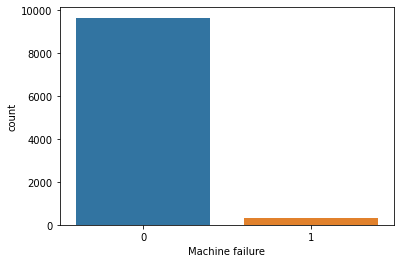

In [ ]:
sns.countplot(pDm_df['Machine failure']);

###There is currently a total of 339 Machine failures in this dataset, which is a large imbalance in favor of the Non-machine failures!!  This is not what I want because it will skew the performance of the classification model.

##Handle imbalanced data for classification

I plan to UPSAMPLE the data so that the count in the minority class (==1, the target) matches with the majority class (==0).

In [ ]:
##Modified code:  https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/

from sklearn.utils import resample

#create two different dataframe of majority and minority class 
pDm_df_majority = pDm_df[(pDm_df['Machine failure']==0)] 
pDm_df_minority = pDm_df[(pDm_df['Machine failure']==1)] 

# upsample minority class
pDm_df_minority_upsampled = resample(pDm_df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 9661, # to match majority class
                                 random_state=42)  # reproducible results

# Combine majority class with upsampled minority class
pDm_df_upsampled = pd.concat([pDm_df_minority_upsampled, pDm_df_majority])

In [ ]:
#check UPSAMPLED number of Machine failures in dataset
pDm_df_upsampled['Machine failure'].value_counts()

1    9661
0    9661
Name: Machine failure, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


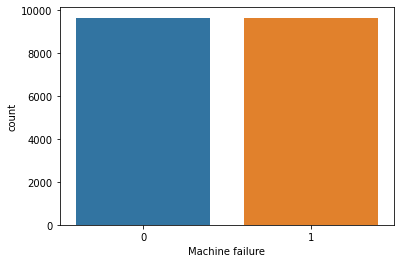

In [ ]:
# view UPSAMPLED plot
sns.countplot(pDm_df_upsampled['Machine failure']);

In [ ]:
#tool wear failure row count resulting in machine failure
pDm_df_upsampled.groupby(['Machine failure', 'TWF']).count()

UID  Product ID  Type  Air temperature [K]  \
Machine failure TWF                                                
0               0    9661        9661  9661                 9661   
1               0    8383        8383  8383                 8383   
                1    1278        1278  1278                 1278   

                     Process temperature [K]  Rotational speed [rpm]  \
Machine failure TWF                                                    
0               0                       9661                    9661   
1               0                       8383                    8383   
                1                       1278                    1278   

                     Torque [Nm]  Tool wear [min]   HDF   PWF   OSF   RNF  
Machine failure TWF                                                        
0               0           9661             9661  9661  9661  9661  9661  
1               0           8383             8383  8383  8383  8383  8383  
                1           1278             1278  1278  1278  1278  1278

###Tool wear failures are 13.23% causal of Machine failures.

In [ ]:
#heat dissipation failure row count resulting in machine failure
pDm_df_upsampled.groupby(['Machine failure', 'HDF']).count()

UID  Product ID  Type  Air temperature [K]  \
Machine failure HDF                                                
0               0    9661        9661  9661                 9661   
1               0    6335        6335  6335                 6335   
                1    3326        3326  3326                 3326   

                     Process temperature [K]  Rotational speed [rpm]  \
Machine failure HDF                                                    
0               0                       9661                    9661   
1               0                       6335                    6335   
                1                       3326                    3326   

                     Torque [Nm]  Tool wear [min]   TWF   PWF   OSF   RNF  
Machine failure HDF                                                        
0               0           9661             9661  9661  9661  9661  9661  
1               0           6335             6335  6335  6335  6335  6335  
                1           3326             3326  3326  3326  3326  3326

###Heat dissipation failure is the #1 independent failure type resulting in Machine failures, roughly 34.42% causal.

In [ ]:
#power failure row count resulting in machine failure
pDm_df_upsampled.groupby(['Machine failure', 'PWF']).count()

UID  Product ID  Type  Air temperature [K]  \
Machine failure PWF                                                
0               0    9661        9661  9661                 9661   
1               0    6919        6919  6919                 6919   
                1    2742        2742  2742                 2742   

                     Process temperature [K]  Rotational speed [rpm]  \
Machine failure PWF                                                    
0               0                       9661                    9661   
1               0                       6919                    6919   
                1                       2742                    2742   

                     Torque [Nm]  Tool wear [min]   TWF   HDF   OSF   RNF  
Machine failure PWF                                                        
0               0           9661             9661  9661  9661  9661  9661  
1               0           6919             6919  6919  6919  6919  6919  
                1           2742             2742  2742  2742  2742  2742

###Power failure is the #3 independent failure type resulting in Machine failure, roughly 28.38% causal

In [ ]:
#overstrain failure row count resulting in machine failure
pDm_df_upsampled.groupby(['Machine failure', 'OSF']).count()

UID  Product ID  Type  Air temperature [K]  \
Machine failure OSF                                                
0               0    9661        9661  9661                 9661   
1               0    6908        6908  6908                 6908   
                1    2753        2753  2753                 2753   

                     Process temperature [K]  Rotational speed [rpm]  \
Machine failure OSF                                                    
0               0                       9661                    9661   
1               0                       6908                    6908   
                1                       2753                    2753   

                     Torque [Nm]  Tool wear [min]   TWF   HDF   PWF   RNF  
Machine failure OSF                                                        
0               0           9661             9661  9661  9661  9661  9661  
1               0           6908             6908  6908  6908  6908  6908  
                1           2753             2753  2753  2753  2753  2753

###Overstrain failure is the #2 independent failure type resulting in Machine failures, roughly 28.49% causal.

In [ ]:
#random failure resulting in machine failure
pDm_df_upsampled.groupby(['Machine failure', 'RNF']).count()

UID  Product ID  Type  Air temperature [K]  \
Machine failure RNF                                                
0               0    9643        9643  9643                 9643   
                1      18          18    18                   18   
1               0    9634        9634  9634                 9634   
                1      27          27    27                   27   

                     Process temperature [K]  Rotational speed [rpm]  \
Machine failure RNF                                                    
0               0                       9643                    9643   
                1                         18                      18   
1               0                       9634                    9634   
                1                         27                      27   

                     Torque [Nm]  Tool wear [min]   TWF   HDF   PWF   OSF  
Machine failure RNF                                                        
0               0           9643             9643  9643  9643  9643  9643  
                1             18               18    18    18    18    18  
1               0           9634             9634  9634  9634  9634  9634  
                1             27               27    27    27    27    27

###Random failures are .2794% causal of Machine failures.

###Oddly, 18 random failures did NOT result in a Machine failures.

#Visualizations - Exploratory Data Analysis

In [ ]:
# use pandas.melt to reshape the dataframe and visualize causal relationship 
# between independent failures and machine failure

# Modified code: https://stackoverflow.com/questions/38807895/seaborn-multiple-barplots,
# https://pandas.pydata.org/docs/reference/api/pandas.melt.html

new_pDm_df = pd.melt(pDm_df_upsampled, id_vars=['Machine failure'], value_vars=['TWF', 'HDF', 'PWF', 'OSF', 'RNF'], 
                     var_name='Type failure', value_name='Type failure value')

new_pDm_df.head()



,Machine failure,Type failure,Type failure value
0,1,TWF,0
1,1,TWF,0
2,1,TWF,0
3,1,TWF,1
4,1,TWF,0


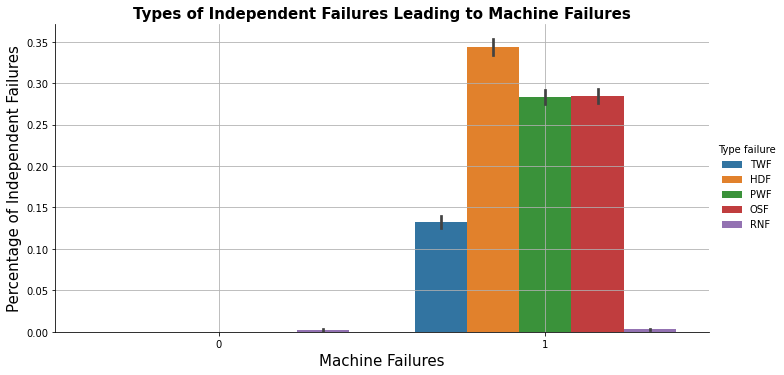

In [ ]:
# create a barplot explaining causes for machine failures
sns.catplot(x='Machine failure', y='Type failure value', hue='Type failure', data=new_pDm_df, kind='bar', height=5, aspect=2)
plt.grid()
plt.title('Types of Independent Failures Leading to Machine Failures', fontweight='bold', fontsize=15)
plt.xlabel('Machine Failures', fontsize=15)
plt.ylabel('Percentage of Independent Failures', fontsize=15);

###This barplot shows Type independent failure totals (by percent) and clearly graphs the TOP 3 categories:


1.   HDF which precede ~34% of machine failures (1)
2.   OSF which precede ~28% of machine failures
3.   PWF which precede ~26% of machine failures

###A very small percentage of Random Failures - RNF - (about .001%) occurred but they did not cause a Machine Failure (0 = no machine failure).

###Although the machine model does not distinguish between which indepedent failure triggers a machine failure, I decided to keep their columns to investigate which indepedent failure occur most frequently in this dataset.  This could provide insight into common precursors to full machine failure.

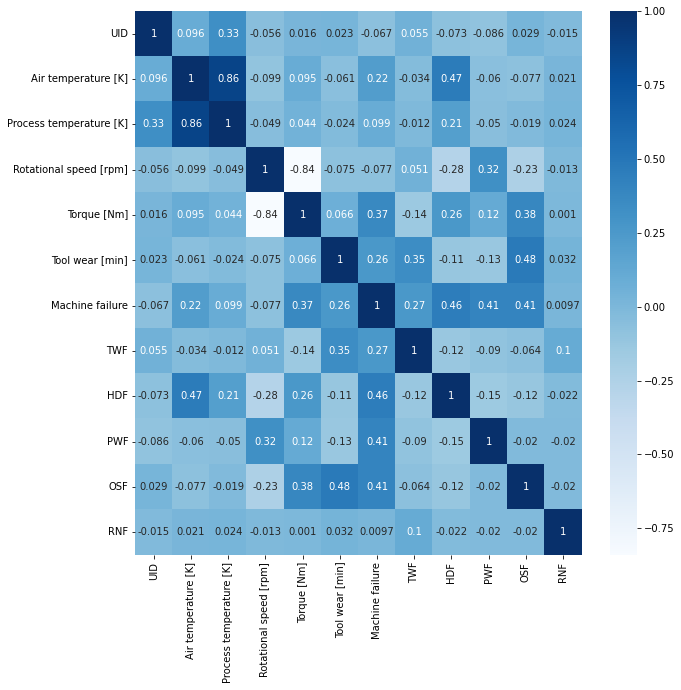

In [ ]:
#create a heatmap variable
corr = pDm_df_upsampled.corr()

# add correlation coefficients to heatmap with annot = True
plt.subplots(figsize=(10,10))
sns.heatmap(corr, cmap = 'Blues', annot = True);

###This heatmap further confirms that HDF, OSF and PWF independent failures (scores .46, .41, .41, respectively) are strongly correlated with Machine Failure

###Process Temperature and Air Temperature have a strong postive correlation with .86 scores

###Rotational Speed and Torque have a strong negative correlation with a -.84 score

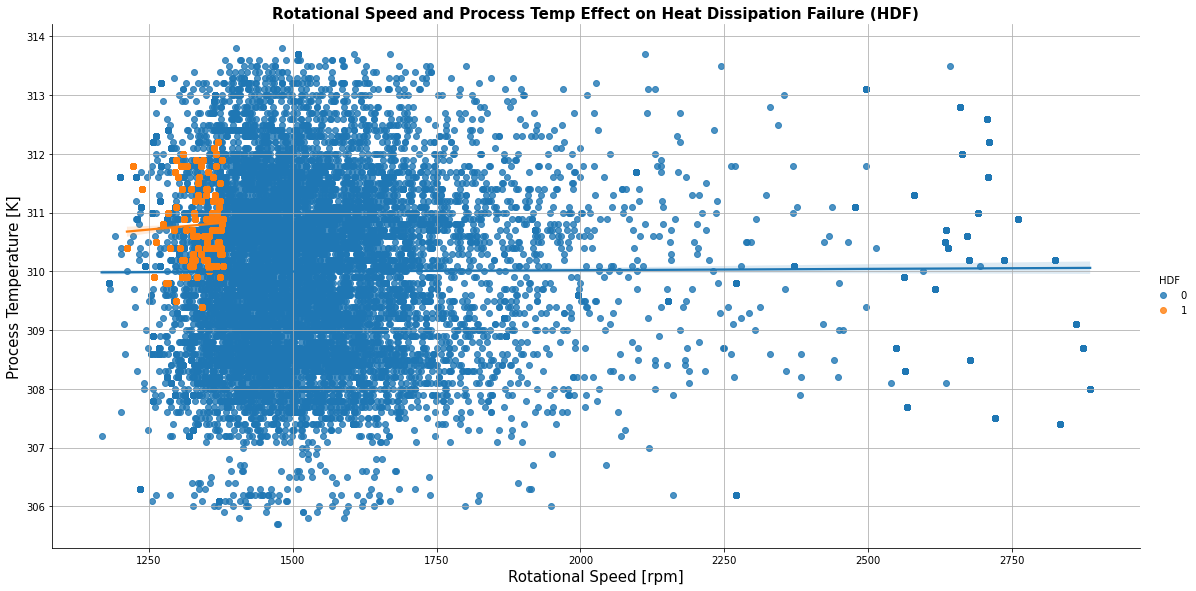

In [ ]:
# explore multiple linear regression plot for Process temperature and Rotational speed effect on HDF

sns.lmplot(data=pDm_df_upsampled, x='Rotational speed [rpm]', y='Process temperature [K]', hue='HDF', height=8, aspect=2)
plt.grid()
plt.title('Rotational Speed and Process Temp Effect on Heat Dissipation Failure (HDF)', fontweight='bold', fontsize=15)
plt.xlabel('Rotational Speed [rpm]', fontsize=15)
plt.ylabel('Process Temperature [K]', fontsize=15);

###This unique scatterplot allows me to explore interactions with categorical variables and it seems to show that the HDF type failure occurs most when between 1250-1375 rpm Rotational Speed and 309.5 - 312 kelvin Process Temperature.

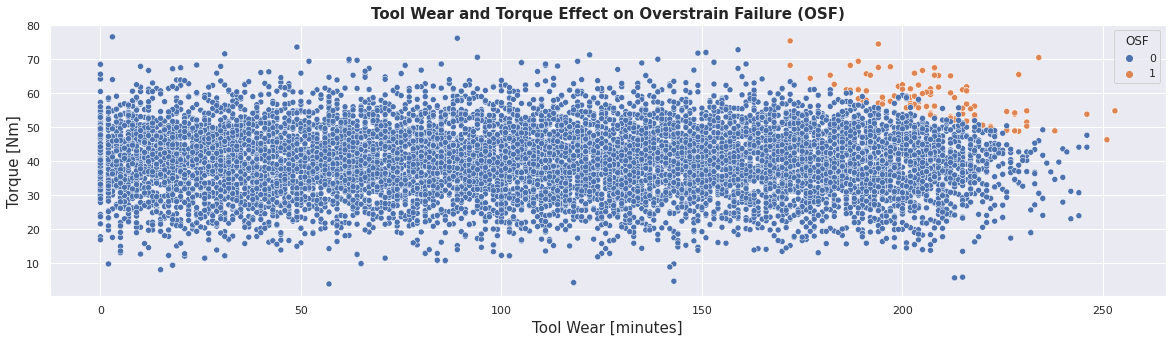

In [ ]:
# explore Tool wear and torque on OSF 
plt.subplots(figsize=(20,5))
sns.scatterplot(data=pDm_df_upsampled, x='Tool wear [min]', y='Torque [Nm]', hue='OSF')
plt.title('Tool Wear and Torque Effect on Overstrain Failure (OSF)', fontweight='bold', fontsize=15)
plt.xlabel('Tool Wear [minutes]', fontsize=15)
plt.ylabel('Torque [Nm]', fontsize=15);

###Based on this lineplot, Overstrain Failures (Tool Wear x Torque) occur most frequently between 11,550 - 12,000 min-Nm or between 165 - 250 Tool Wear min and 50 - 70 Torque Nm.

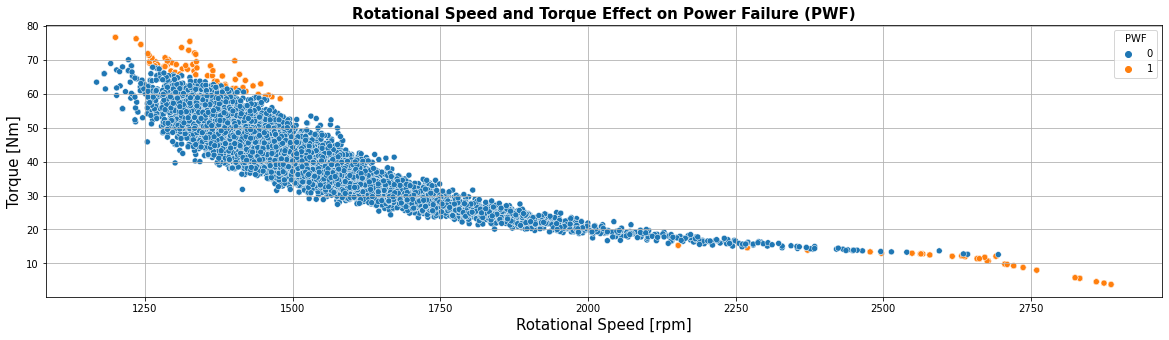

In [ ]:
# explore Rotational speed and torque effect on PWF
plt.subplots(figsize=(20,5))
sns.scatterplot(data=pDm_df_upsampled, x='Rotational speed [rpm]', y='Torque [Nm]', hue='PWF')
plt.title('Rotational Speed and Torque Effect on Power Failure (PWF)', fontweight='bold', fontsize=15)
plt.grid()
plt.xlabel('Rotational Speed [rpm]', fontsize=15)
plt.ylabel('Torque [Nm]', fontsize=15);

###Interestingly, this chart shows PWF (Torque x Speed (in radians/sec)) and ultimately Machine Failure occurs most in two instances: 

1.  Low Rotational Speed and High Torque (1250-1500 rpm and 60-75 Nm) OR PWF above ~7853 Watts

2.  High Rotational Speed and Low Torque (2500-2875 rpm and 3-12 Nm) OR PWF below ~3612 Watts



#Prepare data for Machine Learning

In [ ]:
pDm_df_upsampled['Type'].replace({'L': 0, 'M': 1, 'H': 2}, inplace=True)
pDm_df_upsampled['Type'].value_counts()

0    12465
1     5274
2     1583
Name: Type, dtype: int64

In [ ]:
# Align all datatypes with data dictionary
pDm_df_upsampled['Type'] = pDm_df_upsampled['Type'].astype(object)

In [ ]:
# Determine target(y) and features(X) vectors
X = pDm_df_upsampled.drop(columns=['Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Machine failure'])
y = pDm_df_upsampled['Machine failure']

X.head()

,UID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
4024,4025,1,302.1,311.0,1351,60.3,207
6618,6619,1,301.6,310.6,1309,65.8,75
4048,4049,0,301.9,311.0,2691,12.1,31
2864,2865,2,300.6,309.4,1380,47.6,246
4596,4597,0,303.0,311.2,1361,47.6,106


###Since Machine failure is the true target, I had to drop the five independent failure features from the dataset to ensure the integrity of the training and test predictions.

In [ ]:
#Split the data into training and validation sets

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#Class Balance

In [ ]:
#Check the balance of classes
print(y.value_counts(normalize=True))

1    0.5
0    0.5
Name: Machine failure, dtype: float64


##So, 50% of model predictions are actual machine failures ('positive' class) based on upsampling of imbalanced dataset.  I anticipate the model predictions will hopefully improve since the dataset is split down the middle.

##Select data for preprocessing, create pipeline, fit training data to model

In [ ]:
cat_select = make_column_selector(dtype_include='object')
num_select = make_column_selector(dtype_include='number')

# add (scaler, selector) to preprocessor
preprocess = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), num_select),
                                             ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_select)],
                               remainder = 'drop')

In [ ]:
# create pipeline with preprocessor and XGB model
xgb_pipe = Pipeline(steps=[('preprocessor', preprocess), 
                           ('model', XGBClassifier())])

In [ ]:
# fit model to data
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1c9a961d90>),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1c9a961990>)])),
                ('model', XGBClassifier())])

In [ ]:
# predict values for the training and test set
train_preds = xgb_pipe.predict(X_train)
test_preds = xgb_pipe.predict(X_test)

##Visualize Classifier Model Performance

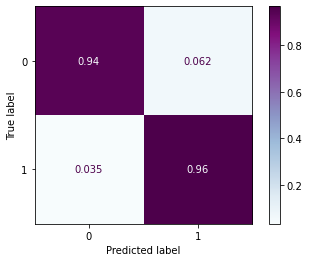

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, cmap='BuPu', normalize='true');

In [ ]:
#Use classification_report() to print a report of several metrics for all classes at once
#for the model

test_report_xgb = classification_report(y_test, test_preds)
print('Classification Reporting for Test Set (XGB):')
print(test_report_xgb)

Classification Reporting for Test Set (XGB):
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2405
           1       0.94      0.96      0.95      2426

    accuracy                           0.95      4831
   macro avg       0.95      0.95      0.95      4831
weighted avg       0.95      0.95      0.95      4831



The XGBClassifier model performed well as evidenced by its classification report heatmap which indicates 94% precision and an average of 96% recall.  Translation: basically 0 (.062%) false positives and .035% false negatives for this model. Accuracy is 95% with the upsampled and more balanced dataset!

##More EDA for fun


In [ ]:
#Explore additional correlations between target (Machine failures) and selected features (X)
pDm_df2 = pd.melt(pDm_df_upsampled, id_vars=['Machine failure'], value_vars=['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'], 
                     var_name='features', value_name='value')

pDm_df2.head()

,Machine failure,features,value
0,1,Air temperature [K],302.1
1,1,Air temperature [K],301.6
2,1,Air temperature [K],301.9
3,1,Air temperature [K],300.6
4,1,Air temperature [K],303.0


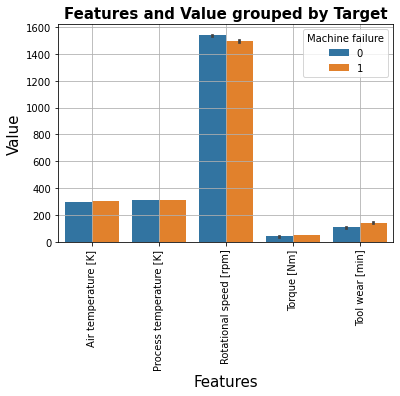

In [ ]:
sns.barplot(data=pDm_df2, x='features', y='value', hue='Machine failure')
plt.title('Features and Value grouped by Target', fontweight='bold', fontsize=15)
plt.grid()
plt.xlabel('Features', fontsize=15)
plt.ylabel('Value', fontsize=15);
plt.xticks(rotation=90);

These appear to be good features to explore in this dataset based on the barplot.

The most machine failures are tied to Rotational speed and Temperature (Air and Process)

In [ ]:
#drop unnecessary columns/features from dataset
km_df = pDm_df_upsampled.drop(columns=['UID', 'Product ID', 'Type', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])

In [ ]:
km_df.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
4024,302.1,311.0,1351,60.3,207,1
6618,301.6,310.6,1309,65.8,75,1
4048,301.9,311.0,2691,12.1,31,1
2864,300.6,309.4,1380,47.6,246,1
4596,303.0,311.2,1361,47.6,106,1


In [ ]:
#Establish clusters based on Air temperature [K], Process temperature [K], Rotational speed [rpm], Torque [Nm] and Tool wear [min]
#Determine optimal clusters
#Make a scatterplot and color code based on clusters

# Instantiate Standard Scaler to normalize dataset values for ML
scaler = StandardScaler()
# Fit & transform data.
scaled_km_df = scaler.fit_transform(km_df)

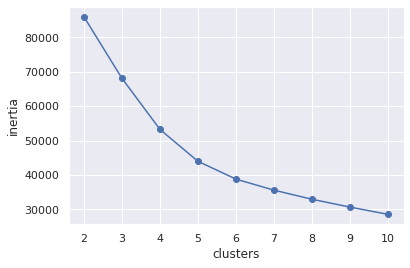

In [ ]:
#Create an empty list of inertias
inertias = []
#Loop through k values between 2 and 11 and store the inertias in the list.
for k in range(2,11):  
  kmeans = KMeans(n_clusters=k)  
  kmeans.fit(scaled_km_df)  
  inertias.append(kmeans.inertia_)

#Visualize scores
plt.plot(range(2,11), inertias, marker = 'o')
plt.xlabel('clusters')
plt.ylabel('inertia');

There is an elbow at 4 and 5, but I will choose 5 in this case since it appears to be the lowest point in the plot before starting to level out.

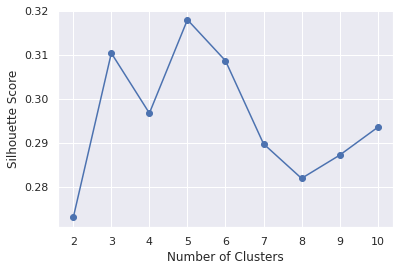

In [ ]:
# Visualize different silhouette scores
# Save silhouette scores for various cluster numbers in list
silhouette_scores = []
for i in range(2, 11):
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(scaled_km_df)
  silhouette_scores.append(silhouette_score(scaled_km_df, kmeans.labels_))

# Visualize scores
plt.plot(range(2, 11), silhouette_scores, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

The highest silhouette score is 5 based on this plot.

In [ ]:
# I am going to fit 2 different KMeans models, one with 4 clusters and one with 5 clusters to see contrast
kmeans4 = KMeans(n_clusters = 4)
kmeans5 = KMeans(n_clusters = 5)
kmeans4.fit(scaled_km_df)
kmeans5.fit(scaled_km_df)

KMeans(n_clusters=5)

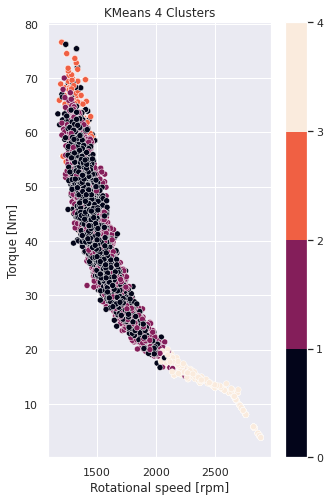

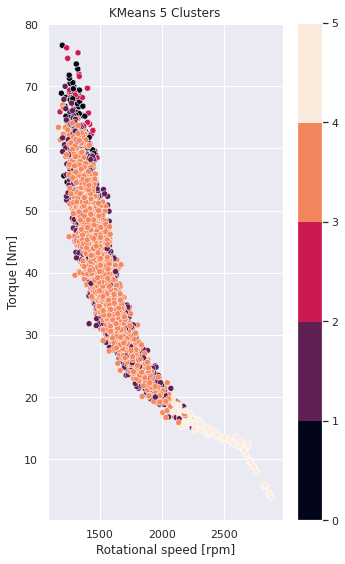

In [ ]:
# Save the cluster labels to the dataframe 
km_df['cluster4'] = kmeans4.labels_
km_df['cluster5'] = kmeans5.labels_

# Visualize the clusters for Rotational speed and Torque
# Modified code: https://stackoverflow.com/questions/63060980/uniform-tick-labels-for-non-linear-colorbar-in-matplotlib

#First KMeans plot
print('\n')
plt.subplots(figsize=(5,8))
ax = sns.scatterplot(data=km_df, x='Rotational speed [rpm]', y='Torque [Nm]', c = km_df['cluster4'])

# normalize bound values
bounds = [0,1,2,3,4]
norm = mpl.colors.BoundaryNorm(bounds, ncolors=256)

sm = plt.cm.ScalarMappable(norm=norm)
ax.figure.colorbar(sm)
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Torque [Nm]')
plt.title('KMeans 4 Clusters')

# Second KMeans plot
plt.subplots(figsize=(5,8))
ax = sns.scatterplot(data=km_df, x='Rotational speed [rpm]', y='Torque [Nm]', c= km_df['cluster5'])

# normalize bound values
bounds = [0,1,2,3,4,5]
norm = mpl.colors.BoundaryNorm(bounds, ncolors=256)

sm = plt.cm.ScalarMappable(norm=norm)
ax.figure.colorbar(sm)
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Torque [Nm]')
plt.title('KMeans 5 Clusters')
plt.tight_layout()


##K-Means Analysis 1

###Cross-referencing EDA I completed earlier on this project:

1) KMeans 4 Cluster - the TAN cluster is the data group that drives machine failures for Rotational speed [rpm] and Torque [Nm] ranges

2) KMeans 5 Cluster - the TAN and a small portion of the tail-end PURPLE cluster are the groups that drive machine failures for process temp and Torque ranges

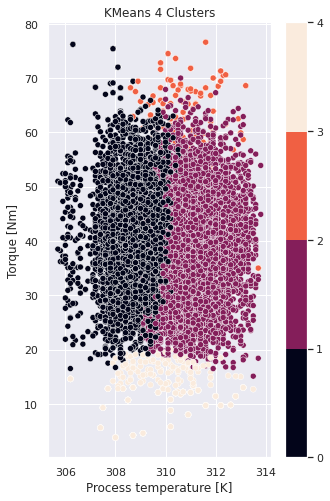

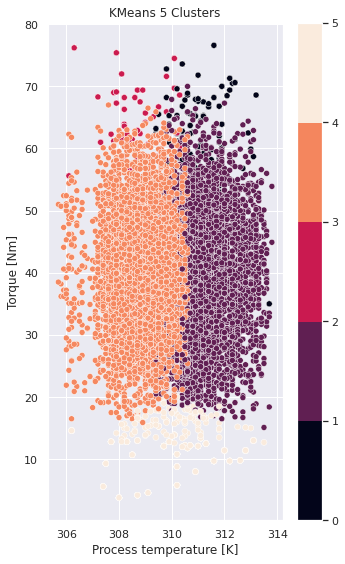

In [ ]:
# Visualize the clusters for Process temperature and Torque

#First KMeans plot
print('\n')
plt.subplots(figsize=(5,8))
ax = sns.scatterplot(data=km_df, x='Process temperature [K]', y='Torque [Nm]', c = km_df['cluster4'])

# normalize bound values
bounds = [0,1,2,3,4]
norm = mpl.colors.BoundaryNorm(bounds, ncolors=256)

sm = plt.cm.ScalarMappable(norm=norm)
ax.figure.colorbar(sm)

plt.xlabel('Process temperature [K]')
plt.ylabel('Torque [Nm]')
plt.title('KMeans 4 Clusters')

#Second KMeans plot
plt.subplots(figsize=(5,8))
ax = sns.scatterplot(data=km_df, x='Process temperature [K]', y='Torque [Nm]', c= km_df['cluster5'])

# normalize bound values
bounds = [0,1,2,3,4,5]
norm = mpl.colors.BoundaryNorm(bounds, ncolors=256)

sm = plt.cm.ScalarMappable(norm=norm)
ax.figure.colorbar(sm)

plt.xlabel('Process temperature [K]')
plt.ylabel('Torque [Nm]')
plt.title('KMeans 5 Clusters')
plt.tight_layout()

##K-Means Analysis 2

###Cross-referencing EDA I completed earlier on this project:

1) KMeans 4 Cluster - the RED cluster is the data group that drives machine failures for process temp and Torque ranges

2) KMeans 5 Cluster - the ORANGE and a small portion of the PURPLE cluster are the groups that drive machine failures for process temp and Torque ranges